In [1]:
import sys
import numpy as np
import torch 

# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from importlib import reload
# get UMAP
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

# import factor model from beta-dirichlet-factor
sys.path.append('/gpfs/commons/home/kisaev/Leaflet-private/src/beta-binomial-mix')
import betabinomo_mix_singlecells as bbmix
import cell_state_asign_consistency as cellassign

reload(bbmix)
reload(cellassign)

<module 'cell_state_asign_consistency' from '/gpfs/commons/home/kisaev/Leaflet-private/src/beta-binomial-mix/cell_state_asign_consistency.py'>

In [2]:
# Append this directory to sys.path
sys.path.append('/gpfs/commons/home/kisaev/Leaflet-private/src/clustering/')
import Leaflet_load_cluster_data_03 as llc 

# append utils 
sys.path.append('/gpfs/commons/home/kisaev/Leaflet-private/src/utils/')
import helpers as ut
import visualization as vis

### Mouse mammary gland data 

In [7]:
use_metadata = False
# organ="Liver"
# load any metadata that is available so that we can run differential splicing analysis between specific cell types
# adata = sc.read_h5ad("/gpfs/commons/datasets/controlled/CZI/tabula-sapiens/TS_figshare/TabulaSapiens.h5ad")
# metadata = adata.obs 
# filter first by organ_tissue
# metadata = metadata[metadata["organ_tissue"]==organ]
# metadata = metadata[["organ_tissue", "free_annotation", "cell_ontology_class", "compartment"]].drop_duplicates()
# drop index 
# metadata = metadata.reset_index(drop=True)
# rename cell_ontology_class to cell_type 
# metadata = metadata.rename(columns={"cell_ontology_class" : "cell_type"})
# metadata.head()
# use_metadata = True

In [3]:
# set device to cuda if available 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# set float type to torch.float to save memory
float_type = { 
    "device" : device, 
    "dtype" : torch.float, 
}

cpu


In [8]:
# input_files_folder = '/gpfs/commons/projects/CZI-tabula-sapiens/Leaflet-Analysis/Leaflet-Intron-Clusters/Liver/'
# input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'
# input_files_folder = "/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/model_input/"
input_files_folder = "/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/model_input/Mammary_Gland/"

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = llc.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=10000, remove_singletons=True, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")
cell_index_tensor, junc_index_tensor, my_data = llc.make_torch_data(final_data, **float_type)

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/model_input/Mammary_Gland/
Finished reading in data from folder ...
Removing singletons ...
Number of junctions before removing singletons:  157665
Number of junctions after removing singletons:  47015
The number of unique cell types in the data is:  4
The number of unique cells in the data is:  2405
The number of unique junctions in the data is:  47016
The maximum junction count was initially:  251545
156
The maximum junction count is now:  9934
The number of junctions in the data is:  45664
The number of cells in the data is:  2405
The number of cell types in the data is:  4
The number of cells going into training data is:
2405
2405


In [9]:
# merge cell_ids_conversion with metadata to add more cell type information
if use_metadata is True:
    metadata["cell_type"] = metadata["free_annotation"]
    cell_ids_conversion = cell_ids_conversion.merge(metadata, on="cell_type")

simple_data_human = final_data[["cell_id_index", "Cluster", "cell_type", "junction_id_index", "juncratio", "junc_count", "cluster_count",  "junction_id", "gene_id"]]

In [10]:
print("The number of junctions is: ", len(junction_ids_conversion))
print("The number of intron clusters observed is: ", len(junction_ids_conversion.Cluster.unique()))
print("The number of genes is: ", len(junction_ids_conversion.gene_id.unique()))

The number of junctions is:  45664
The number of intron clusters observed is:  11726
The number of genes is:  7759


In [11]:
cell_index_tensor, junc_index_tensor, my_data = llc.make_torch_data(final_data, **float_type)

The number of cells going into training data is:
2405
2405


In [12]:
cell_ids_conversion['cell_type'].value_counts()

Mammary_Gland_basal_cell                                  1340
Mammary_Gland_luminal_epithelial_cell_of_mammary_gland     578
Mammary_Gland_stromal_cell                                 440
Mammary_Gland_endothelial_cell                              47
Name: cell_type, dtype: int64

### Run Binomial mixture model!

In [14]:
torch.manual_seed(42)
np.random.seed(42)

K = len(cell_ids_conversion.cell_type.unique())
print(K)

hypers = {
    "eta" : 1./K, 
    "alpha_prior" : 1., 
    "pi_prior" : 1.
}

print(hypers["eta"])

4
0.25


In [15]:
init_labels = cell_ids_conversion["cell_type"]
# Set GAMMA to dummy values based on the initial labels
cell_type_dummy = pd.get_dummies(init_labels)
cell_type_dummy_columns = cell_type_dummy.columns
# make dataframe of cell_type_dummy_columns and index from 0 to len(cell_type_dummy_columns)
cell_type_dummy_df = pd.DataFrame(cell_type_dummy_columns, columns=["cell_type"])
cell_type_dummy_df["cell_type_index"] = range(len(cell_type_dummy_columns))
# we will just save this here for now and run CAVI and map everything back after before doing differential splicing analysis 
cell_type_dummy_df

,cell_type,cell_type_index
0,Mammary_Gland_basal_cell,0
1,Mammary_Gland_endothelial_cell,1
2,Mammary_Gland_luminal_epithelial_cell_of_mamma...,2
3,Mammary_Gland_stromal_cell,3


In [16]:
num_trials = 5 # should also be an argument that gets fed in
num_iters = 100 # should also be an argument that gets fed in
print("The K used is: ", K)
results = [ bbmix.calculate_CAVI(K, my_data, float_type, hypers, init_labels = init_labels, num_iterations = num_iters, fixed_cell_types = True) 
           for t in range(num_trials) ]

The K used is:  4
Initialize VI params
Initializing variational parameters with N = 2405 cells and J = 45664 junctions
Initializing cell state proportions with init_labels
Running CAVI with fixed cell types
z and theta will not be updated!
Got the initial ELBO ^
The tolerance is set to  0.001
ELBO converged @ -908774784.0 CAVI iteration # 2 complete
ELBO converged @ -908774784.0 CAVI iteration # 2 complete
Finished CAVI!
Initialize VI params
Initializing variational parameters with N = 2405 cells and J = 45664 junctions
Initializing cell state proportions with init_labels
Running CAVI with fixed cell types
z and theta will not be updated!
Got the initial ELBO ^
The tolerance is set to  0.001
ELBO converged @ -908774784.0 CAVI iteration # 2 complete
ELBO converged @ -908774784.0 CAVI iteration # 2 complete
Finished CAVI!
Initialize VI params
Initializing variational parameters with N = 2405 cells and J = 45664 junctions
Initializing cell state proportions with init_labels
Running CAVI w

### Evaluate the learned posteriors

In [17]:
best = np.argmax([ g[-1][-1] for g in results ]) # final ELBO
print(f"The trial with the highest ELBO was {best}")
ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = results[best]
elbos_all = np.array(elbos_all)
elbos_all

The trial with the highest ELBO was 0


array([-2.50352077e+09, -9.08774784e+08, -9.08774784e+08])

### Differential junction usage analysis

In [18]:
cell_type_dummy_df

,cell_type,cell_type_index
0,Mammary_Gland_basal_cell,0
1,Mammary_Gland_endothelial_cell,1
2,Mammary_Gland_luminal_epithelial_cell_of_mamma...,2
3,Mammary_Gland_stromal_cell,3


In [20]:
# let's compare first two cell types 
cell_type1_index = 0
cell_type2_index = 1

In [21]:
juncs_probs = ALPHA_f / (ALPHA_f+PI_f)   
alpha_plus_pi = ALPHA_f+PI_f

juncs_probs.shape

torch.Size([45664, 4])

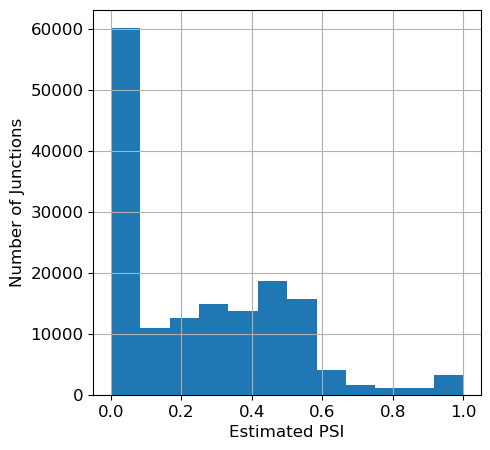

In [22]:
# Create boolean mask from tensor1
mask = alpha_plus_pi >= 10

# Apply the mask to tensor2 to get filtered values
filtered_values = juncs_probs[mask]

plt.figure(figsize=(5, 5))
# Plot the values
plt.hist(filtered_values.numpy(), bins=12)  # Assuming you want a histogram, adjust as needed
plt.xlabel('Estimated PSI', fontsize=12)
# Set y-label with larger font size (if you need it)
plt.ylabel('Number of Junctions', fontsize=12)  
# Increase tick label size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# add grid 
plt.grid()

In [23]:
juncs_probs_df = pd.DataFrame(juncs_probs, columns = range(K))
juncs_probs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values
# convert to juncs_probs to pandas dataframe and calculate mean and std across cell states/topics
juncs_probs_df["junction_id"] = junction_ids_conversion.junction_id.values
juncs_probs_df.head()

,0,1,2,3,junction_id_index,junction_id
0,0.445505,0.452899,0.432304,0.389639,0,1_160044753_160070699
1,0.451250,0.448551,0.467859,0.426287,1,1_160070803_160075030
2,0.030118,0.017391,0.011962,0.007996,2,1_160070803_160071426
3,0.304236,0.372093,0.278855,0.341508,3,1_155564721_155567584
4,0.127197,0.081395,0.141834,0.122011,4,1_155567681_155601453


In [58]:
scores_all_juncs = []

for junc_index in range(juncs_probs.shape[0]):
    a = ALPHA_f[junc_index, [cell_type1_index, cell_type2_index]]
    b = PI_f[junc_index, [cell_type1_index, cell_type2_index] ]
    scores_all_juncs.append(bbmix.score(a, b).item())

# turn scores_all_juncs into dataframe and add junction_id_index as a column
scores_all_juncs_df = pd.DataFrame(scores_all_juncs, columns = ["score"])
scores_all_juncs_df["junction_id_index"] = junction_ids_conversion.junction_id_index.values

In [59]:
# Compute the logistic score
scores_all_juncs_df["logistic_score"] = 1 / (1 + np.exp(-scores_all_juncs_df["score"].values))

# Compute the Bayesian q-value for FDR
scores_all_juncs_df["q_value"] = 1 - scores_all_juncs_df["logistic_score"].values 
scores_all_juncs_df["significance"] = np.where(scores_all_juncs_df["q_value"].values < 0.01, "yes", "no")

In [60]:
scores_all_juncs_df["significance"].value_counts()

no     38384
yes     7280
Name: significance, dtype: int64

In [61]:
# merge scores_all_juncs_df with junction_ids_conversion to get gene_id and junction_id 
scores_all_juncs_df = scores_all_juncs_df.merge(junction_ids_conversion, on="junction_id_index")
scores_all_juncs_df.sort_values(by="score", ascending=False).head(10)

,score,junction_id_index,logistic_score,q_value,significance,junction_id,Cluster,gene_id
28963,1117.228516,28963,1.0,0.0,yes,6_117173578_117178582,40125,Cxcl12
27096,1117.228516,27096,1.0,0.0,yes,6_117173578_117176085,40125,Cxcl12
12528,848.796875,12528,1.0,0.0,yes,9_31156225_31157694,63383,Aplp2
3813,788.193359,3813,1.0,0.0,yes,9_67036128_67043577,66317,Tpm1
25602,729.111328,25602,1.0,0.0,yes,2_163694156_163703485,10807,Pkig
12526,636.742188,12526,1.0,0.0,yes,9_31153499_31156189,63383,Aplp2
2408,614.078125,2408,1.0,0.0,yes,6_48841589_48842203,41809,Tmem176a
8403,614.078125,8403,1.0,0.0,yes,6_48841710_48842203,41809,Tmem176a
27821,583.986084,27821,1.0,0.0,yes,10_4313857_4353141,66819,Akap12
27125,583.986084,27125,1.0,0.0,yes,10_4357939_4358477,66819,Akap12


In [40]:
cell_type1 = cell_type_dummy_df[cell_type_dummy_df["cell_type_index"]==cell_type1_index]["cell_type"].values[0]
cell_type2 = cell_type_dummy_df[cell_type_dummy_df["cell_type_index"]==cell_type2_index]["cell_type"].values[0]
cell_types = [cell_type1, cell_type2]
print(cell_types)

['Mammary_Gland_basal_cell', 'Mammary_Gland_endothelial_cell']


In [79]:
junc = 7023
clust = ut.get_cluster(junc, junction_ids_conversion)
gene = ut.get_gene(junc, junction_ids_conversion)
print(f"The cluster is {clust} and the gene is {gene}")

The cluster is 1913 and the gene is Lrrfip1


Mammary_Gland_basal_cell          673
Mammary_Gland_endothelial_cell     27
Name: cell_type, dtype: int64


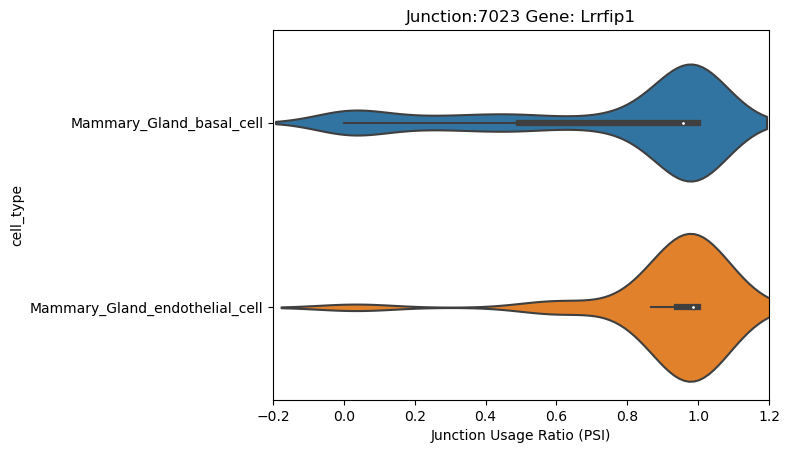

In [80]:
vis.quick_junc_plot(junc, simple_data_human, gene_name=True, cell_types=cell_types)

Mammary_Gland_basal_cell          2019
Mammary_Gland_endothelial_cell      81
Name: cell_type, dtype: int64


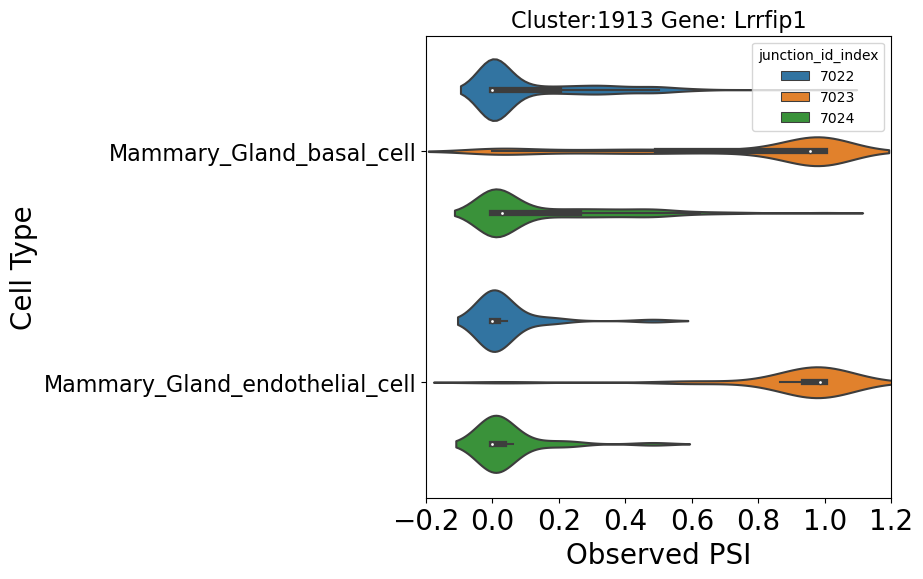

In [81]:
vis.quick_clust_plot(clust, simple_data_human, gene_name=True, cell_types=cell_types)

#### if observe splicing change, is it one that makes you more epithelial vs mammary gland... 
#### C x J, can batch over cells... should maintain scalibility 
#### visualization to show junction in gene context simple local visualization 

In [82]:
# summarize total number of junctions that are significantly differentially spliced between the two
# cell types of interest and also the number of unique genes they belong to

print("The number of junctions that are significantly differentially spliced between the two cell types is: ", scores_all_juncs_df["significance"].value_counts()["yes"])
print("The number of unique genes that these junctions belong to is: ", scores_all_juncs_df[scores_all_juncs_df["significance"]=="yes"]["gene_id"].nunique())

The number of junctions that are significantly differentially spliced between the two cell types is:  7280
The number of unique genes that these junctions belong to is:  3540


In [83]:
# print the gene that has the most number of junctions that are significantly differentially spliced between the two cell types
gene_counts = scores_all_juncs_df[scores_all_juncs_df["significance"]=="yes"]["gene_id"].value_counts()

# print the top 5 genes with the most DS junctions
print("The top 5 genes with the most number of junctions that are significantly differentially spliced between the two cell types are: ")
print(gene_counts.head(5))

The top 5 genes with the most number of junctions that are significantly differentially spliced between the two cell types are: 
Ap3b1      26
Lrrfip1    14
Ttc3       13
Fbln2      13
Gnl3       12
Name: gene_id, dtype: int64


In [78]:
scores_all_juncs_df[scores_all_juncs_df["gene_id"] == "Lrrfip1"].sort_values(by="score", ascending=False).head(10)

,score,junction_id_index,logistic_score,q_value,significance,junction_id,Cluster,gene_id
7023,107.113281,7023,1.0,0.000000e+00,yes,1_91101310_91105126,1913,Lrrfip1
7019,63.137207,7019,1.0,0.000000e+00,yes,1_91053723_91068562,1910,Lrrfip1
7018,63.137207,7018,1.0,0.000000e+00,yes,1_90998893_91068562,1910,Lrrfip1
11417,56.588379,11417,1.0,0.000000e+00,yes,1_91068649_91084945,1911,Lrrfip1
7024,47.774414,7024,1.0,0.000000e+00,yes,1_91103318_91105126,1913,Lrrfip1
7020,43.976562,7020,1.0,0.000000e+00,yes,1_91068649_91100576,1911,Lrrfip1
11418,38.439453,11418,1.0,0.000000e+00,yes,1_91085005_91100576,1911,Lrrfip1
7022,37.984375,7022,1.0,0.000000e+00,yes,1_91101310_91103246,1913,Lrrfip1
25243,17.478027,25243,1.0,2.566783e-08,yes,1_91079081_91084945,1911,Lrrfip1
108,14.957031,108,1.0,3.193329e-07,yes,1_91112297_91114595,1915,Lrrfip1


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000'),
  Text(0, 8000.0, '8000')])

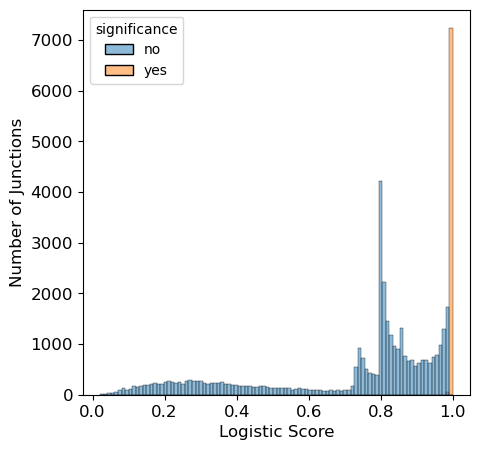

In [106]:
# plot logisitic score distribution color by significance
plt.figure(figsize=(5, 5))
sns.histplot(data=scores_all_juncs_df, x="logistic_score", hue="significance", bins=100, kde=False)
plt.xlabel('Logistic Score', fontsize=12)
plt.ylabel('Number of Junctions', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000'),
  Text(0, 8000.0, '8000')])

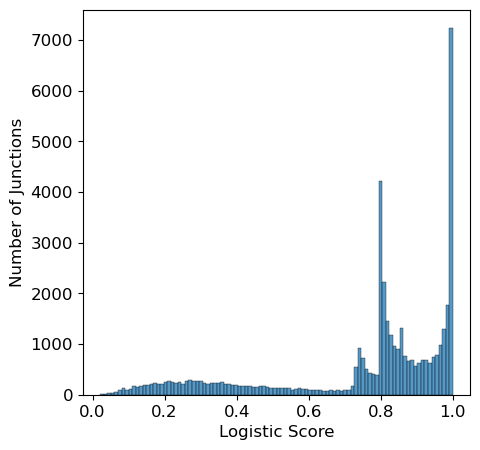

In [104]:
plt.figure(figsize=(5, 5))
sns.histplot(data=scores_all_juncs_df, x="logistic_score", bins=100)
plt.xlabel('Logistic Score', fontsize=12)
plt.ylabel('Number of Junctions', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
